# Defining the systems and inputs

In [15]:
from __future__ import division
from pyomo.environ import *
from pyomo.gdp import *
import random
from pyomo.opt import SolverFactory,SolverStatus,TerminationCondition
from pyutilib.misc.timing import tic,toc
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from pyomo.environ import log as pyolog
from pyomo.environ import exp as pyoexp
from pyomo.bilevel import *
import seaborn as sns
import pandas as pd
import math

# solvers options
quadsol = 'cplex'
nlpsol = 'ipopt'
minlpsol = 'scipampl'
mipsol = 'cplex'
bisol = 'bilevel_blp_global'

infinity = float('inf')

In [16]:
class Lib:
    # create network topoloy based on node and link sets
    def Network_topo(N, A):
        def NodesIn_init(n):
            retval = []
            for (i,j) in A:
                if j == n:
                    retval.append(i)
            return retval

        NodesIn = {}
        for n in N:
            NodesIn[n] = NodesIn_init(n)

        def NodesOut_init(n):
            retval = []
            for (i,j) in A:
                if i == n:
                    retval.append(j)
            return retval
        NodesOut = {}
        for n in N:
            NodesOut[n] = NodesOut_init(n)

        return NodesOut, NodesIn
    
class IO():
    
    
    def power_15_node():
        N = list(range(1,16))
        N_CS = [1,2,3]
        N_sub=[1]
        N_DG=[12]
        N_load = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
        N_SD = list(set().union(N_sub, N_DG))
        T = [1]
        cost_sub = {1: 25}
        cost_DG = {12: 10}
        
        V_max = 1.1
        V_min = 0.9
        
        G_cap_p = {1: 2, 12:0.4}
        G_cap_s={}
        
        for i in N_SD:
            G_cap_s[i] = G_cap_p[i]
        
        load_w={}
        for i in N_load:
            load_w[i] = 60
        
        Lines = list(range(1,15))
        
        lamda={}
        for (i) in Lines:
            for t in T:
                lamda[i] = 1
        
        Line_R = {1: 0.001, 2: 0.0883, 3: 0.1384, 4: 0.0191, 5: 0.0175, 6: 0.0482,
                 7: 0.0523, 8: 0.0407, 9: 0.01, 10: 0.0241, 11: 0.0103, 12: 0.001,
                 13: 0.1559, 14: 0.0953}
        
        Line_X = {1: 0.12, 2: 0.1262, 3: 0.1978, 4: 0.0273, 5: 0.0251, 6: 0.0689,
                 7: 0.0747, 8: 0.0582, 9: 0.0143, 10: 0.0345, 11: 0.0148, 12: 0.12,
                 13: 0.1119, 14: 0.0684}
        
        Line_cap = {1: 2, 2: 0.256, 3: 0.256, 4: 0.256, 5: 0.256, 6: 0.256, 7: 0.256, 8: 0.256,
                   9: 0.256, 10: 0.256, 11: 0.256, 12: 1, 13: 0.204, 14: 0.204}
        
        load_p = {2:0.7936, 3: 0, 4: 0.0201, 5: 0.0173, 6: 0.0291, 7: 0.0219, 8: -0.1969,
                 9: 0.0235, 10: 0.0229, 11: 0.0217, 12: 0.0132, 13: 0.6219, 14: 0.0014, 15: 0.0224}
        
        load_q ={2: 0.1855, 3: 0, 4: 0.0084, 5: 0.0043, 6: 0.0073, 7: 0.0055, 8: 0.0019, 9: 0.0059,
                10: 0.0142, 11: 0.0065, 12: 0.0033, 13: 0.1291, 14: 0.0008, 15: 0.0083}
        
        FM ={}
        TM={}
        for i in Lines:
            for j in N:
                FM[i,j] = 0
                TM[i,j] = 0
                if i == j:
                    FM[i,j] = 1
                    
                if j == i+1:
                    TM[i,j]=1

        FM[7,9] = 1
        FM[7,7] = 0
        FM[8,4] = 1
        FM[8,8] = 0
        FM[12,1] = 1
        FM[12,12] = 0
        
        conn = {(1,'FN'): 1, (1,'TN'): 2,
               (2,'FN'): 2, (2,'TN'): 3,
               (3,'FN'): 3, (3,"TN"): 4,
               (4,'FN'): 4, (4,'TN'): 5,
               (5,'FN'): 5, (5,'TN'): 6,
               (6,'FN'): 6, (6,'TN'): 7,
               (7,'FN'): 9, (7,'TN'): 8,
               (8,'FN'): 4, (8,'TN'): 9,
               (9,'FN'): 9, (9,'TN'): 10,
               (10,'FN'): 10, (10,'TN'): 11,
               (11,'FN'): 11, (11,'TN'): 12,
               (12,'FN'): 1, (12,'TN'): 13,
               (13,'FN'): 13, (13,'TN'): 14,
               (14,'FN'): 14, (14,'TN'): 15}
        return Network_power(N, Lines, N_load, N_sub, N_DG, N_CS, T, G_cap_p, G_cap_s, cost_sub, cost_DG, Line_R, Line_X,
                             Line_cap, load_p, load_q, load_w, V_max, V_min, lamda, FM, TM, conn)

        
    def power_33_node():
        
        N = list(range(1,34))
        N_CS = [1,4,6,11,13,16,19,2,23,25,27,32]
#         N_CS = []
        N_load = list(range(2,34))
        N_pv = [18,25,33]
#         N_pv=[]
        N_D = [8,13,30]
        N_DG = list(set().union(N_D, N_pv))
#         N_DG=[]
        T = list(range(1,25))
        N_sub = [1]
        N_SD = list(set().union(N_sub, N_DG))
        
        load_w={}
        for i in N_load:
            load_w[i] = 70
        
        Lines = list(range(1,33))
        
        Line_R = {1: 0.00575, 2: 0.03076, 18: 0.01023, 3: 0.02284, 4: 0.02378, 
                  5: 0.0511, 6: 0.01168, 7: 0.04439, 8: 0.06426, 9: 0.06514,
                  10: 0.01227, 11: 0.02336, 12: 0.09159, 13: 0.03379, 14: 0.03687,
                  15: 0.04656, 16: 0.08042, 17: 0.04567, 19: 0.09385, 20: 0.02555,
                  21: 0.04423, 22: 0.02815, 23: 0.05603, 24: 0.0559, 25: 0.01267,
                  26: 0.01773, 27: 0.06607, 28: 0.05018, 29: 0.03166, 30: 0.0608,
                  31: 0.01937, 32: 0.02128
                 }
        Line_X = {1: 0.00293, 2: 0.01567, 18: 0.00976, 3: 0.01163, 4: 0.01211, 
                  5: 0.04411, 6: 0.03861, 7: 0.01467, 8: 0.04617, 9: 0.04617,
                  10: 0.00406, 11: 0.00772, 12: 0.07206, 13: 0.04448, 14: 0.03282,
                  15: 0.034, 16: 0.10738, 17: 0.03581, 19: 0.08457, 20: 0.02985,
                  21: 0.05848, 22: 0.01924, 23: 0.04424, 24: 0.04374, 25: 0.00645,
                  26: 0.00903, 27: 0.05826, 28: 0.04371, 29: 0.01613, 30: 0.06008,
                  31: 0.02258, 32: 0.03319
                 }
        
        
        Line_cap={}
        
        load_w={}
        for i in N_load:
            load_w[i] = 60
        
        for i in Lines:
            Line_cap[i] = 5
#             Line_R[i] = Line_R[i] *10
#             Line_X[i] = Line_X[i] *10
            
        load_p = {(2,1):0.064,   (2,2):0.065,   (2,3):0.063,    (2,4):0.064,   (2,5):0.07,    (2,6):0.08,   (2,7):0.086,   (2,8):0.084,   (2,9):0.085,    (2,10):0.088,   (2,11):0.091,    (2,12):0.084,   (2,13):0.082,   (2,14):0.085,   (2,15):0.089,    (2,16):0.096,   (2,17):0.099,    (2,18):0.1,    (2,19):0.094,    (2,20):0.09,    (2,21):0.085,    (2,22):0.078,   (2,23):0.072,   (2,24):0.066,
                  (3,1):0.0576,  (3,2):0.0585,  (3,3):0.0567,   (3,4):0.0576,  (3,5):0.063,   (3,6):0.072,  (3,7):0.0774,  (3,8):0.0756,  (3,9):0.0765,   (3,10):0.0792,  (3,11):0.0819,   (3,12):0.0756,  (3,13):0.0738,  (3,14):0.0765,  (3,15):0.0801,   (3,16):0.0864,  (3,17):0.0891,   (3,18):0.09,   (3,19):0.0846,   (3,20):0.081,   (3,21):0.0765,   (3,22):0.0702,  (3,23):0.0648,  (3,24):0.0594,
                  (4,1):0.0768,  (4,2):0.078,   (4,3):0.0756,   (4,4):0.0768,  (4,5):0.084,   (4,6):0.096,  (4,7):0.1032,  (4,8):0.1008,  (4,9):0.102,    (4,10):0.1056,  (4,11):0.1092,   (4,12):0.1008,  (4,13):0.0984,  (4,14):0.102,   (4,15):0.1068,   (4,16):0.1152,  (4,17):0.1188,   (4,18):0.12,   (4,19):0.1128,   (4,20):0.108,   (4,21):0.102,    (4,22):0.0936,  (4,23):0.0864,  (4,24):0.0792,
                  (5,1):0.0384,  (5,2):0.039,   (5,3):0.0378,   (5,4):0.0384,  (5,5):0.042,   (5,6):0.048,  (5,7):0.0516,  (5,8):0.0504,  (5,9):0.051,    (5,10):0.0528,  (5,11):0.0546,   (5,12):0.0504,  (5,13):0.0492,  (5,14):0.051,   (5,15):0.0534,   (5,16):0.0576,  (5,17):0.0594,   (5,18):0.06,   (5,19):0.0564,   (5,20):0.054,   (5,21):0.051,    (5,22):0.0468,  (5,23):0.0432,  (5,24):0.0396,
                  (6,1):0.0384,  (6,2):0.039,   (6,3):0.0378,   (6,4):0.0384,  (6,5):0.042,   (6,6):0.048,  (6,7):0.0516,  (6,8):0.0504,  (6,9):0.051,    (6,10):0.0528,  (6,11):0.0546,   (6,12):0.0504,  (6,13):0.0492,  (6,14):0.051,   (6,15):0.0534,   (6,16):0.0576,  (6,17):0.0594,   (6,18):0.06,   (6,19):0.0564,   (6,20):0.054,   (6,21):0.051,    (6,22):0.0468,  (6,23):0.0432,  (6,24):0.0396,
                  (7,1):0.128,   (7,2):0.13,    (7,3):0.126,    (7,4):0.128,   (7,5):0.14,    (7,6):0.16,   (7,7):0.172,   (7,8):0.168,   (7,9):0.17,     (7,10):0.176,   (7,11):0.182,    (7,12):0.168,   (7,13):0.164,   (7,14):0.17,    (7,15):0.178,    (7,16):0.192,   (7,17):0.198,    (7,18):0.2,    (7,19):0.188,    (7,20):0.18,    (7,21):0.17,     (7,22):0.156,   (7,23):0.144,   (7,24):0.132,
                  (8,1):0.128,   (8,2):0.13,    (8,3):0.126,    (8,4):0.128,   (8,5):0.14,    (8,6):0.16,   (8,7):0.172,   (8,8):0.168,   (8,9):0.17,     (8,10):0.176,   (8,11):0.182,    (8,12):0.168,   (8,13):0.164,   (8,14):0.17,    (8,15):0.178,    (8,16):0.192,   (8,17):0.198,    (8,18):0.2,    (8,19):0.188,    (8,20):0.18,    (8,21):0.17,     (8,22):0.156,   (8,23):0.144,   (8,24):0.132,
                  (9,1):0.0384,  (9,2):0.039,   (9,3):0.0378,   (9,4):0.0384,  (9,5):0.042,   (9,6):0.048,  (9,7):0.0516,  (9,8):0.0504,  (9,9):0.051,    (9,10):0.0528,  (9,11):0.0546,   (9,12):0.0504,  (9,13):0.0492,  (9,14):0.051,   (9,15):0.0534,   (9,16):0.0576,  (9,17):0.0594,   (9,18):0.06,   (9,19):0.0564,   (9,20):0.054,   (9,21):0.051,    (9,22):0.0468,  (9,23):0.0432,  (9,24):0.0396,
                  (10,1):0.0384, (10,2):0.039,  (10,3):0.0378,  (10,4):0.0384, (10,5):0.042,  (10,6):0.048, (10,7):0.0516, (10,8):0.0504, (10,9):0.051,   (10,10):0.0528, (10,11):0.0546,  (10,12):0.0504, (10,13):0.0492, (10,14):0.051,  (10,15):0.0534,  (10,16):0.0576, (10,17):0.0594,  (10,18):0.06,  (10,19):0.0564,  (10,20):0.054,  (10,21):0.051,   (10,22):0.0468, (10,23):0.0432, (10,24):0.0396,
                  (11,1):0.0288, (11,2):0.02925,(11,3):0.02835, (11,4):0.0288, (11,5):0.0315, (11,6):0.036, (11,7):0.0387, (11,8):0.0378, (11,9):0.03825, (11,10):0.0396, (11,11):0.04095, (11,12):0.0378, (11,13):0.0369, (11,14):0.03825,(11,15):0.04005, (11,16):0.0432, (11,17):0.04455, (11,18):0.045, (11,19):0.0423,  (11,20):0.0405, (11,21):0.03825, (11,22):0.0351, (11,23):0.0324, (11,24):0.0297,
                  (12,1):0.0384, (12,2):0.039,  (12,3):0.0378,  (12,4):0.0384, (12,5):0.042,  (12,6):0.048, (12,7):0.0516, (12,8):0.0504, (12,9):0.051,   (12,10):0.0528, (12,11):0.0546,  (12,12):0.0504, (12,13):0.0492, (12,14):0.051,  (12,15):0.0534,  (12,16):0.0576, (12,17):0.0594,  (12,18):0.06,  (12,19):0.0564,  (12,20):0.054,  (12,21):0.051,   (12,22):0.0468, (12,23):0.0432, (12,24):0.0396,
                  (13,1):0.0384, (13,2):0.039,  (13,3):0.0378,  (13,4):0.0384, (13,5):0.042,  (13,6):0.048, (13,7):0.0516, (13,8):0.0504, (13,9):0.051,   (13,10):0.0528, (13,11):0.0546,  (13,12):0.0504, (13,13):0.0492, (13,14):0.051,  (13,15):0.0534,  (13,16):0.0576, (13,17):0.0594,  (13,18):0.06,  (13,19):0.0564,  (13,20):0.054,  (13,21):0.051,   (13,22):0.0468, (13,23):0.0432, (13,24):0.0396,  
                  (14,1):0.0768, (14,2):0.078,  (14,3):0.0756,  (14,4):0.0768, (14,5):0.084,  (14,6):0.096, (14,7):0.1032, (14,8):0.1008, (14,9):0.102,   (14,10):0.1056, (14,11):0.1092,  (14,12):0.1008, (14,13):0.0984, (14,14):0.102,  (14,15):0.1068,  (14,16):0.1152, (14,17):0.1188,  (14,18):0.12,  (14,19):0.1128,  (14,20):0.108,  (14,21):0.102,   (14,22):0.0936, (14,23):0.0864, (14,24):0.0792,
                  (15,1):0.0384, (15,2):0.039,  (15,3):0.0378,  (15,4):0.0384, (15,5):0.042,  (15,6):0.048, (15,7):0.0516, (15,8):0.0504, (15,9):0.051,   (15,10):0.0528, (15,11):0.0546,  (15,12):0.0504, (15,13):0.0492, (15,14):0.051,  (15,15):0.0534,  (15,16):0.0576, (15,17):0.0594,  (15,18):0.06,  (15,19):0.0564,  (15,20):0.054,  (15,21):0.051,   (15,22):0.0468, (15,23):0.0432, (15,24):0.0396,
                  (16,1):0.0384, (16,2):0.039,  (16,3):0.0378,  (16,4):0.0384, (16,5):0.042,  (16,6):0.048, (16,7):0.0516, (16,8):0.0504, (16,9):0.051,   (16,10):0.0528, (16,11):0.0546,  (16,12):0.0504, (16,13):0.0492, (16,14):0.051,  (16,15):0.0534,  (16,16):0.0576, (16,17):0.0594,  (16,18):0.06,  (16,19):0.0564,  (16,20):0.054,  (16,21):0.051,   (16,22):0.0468, (16,23):0.0432, (16,24):0.0396,
                  (17,1):0.0384, (17,2):0.039,  (17,3):0.0378,  (17,4):0.0384, (17,5):0.042,  (17,6):0.048, (17,7):0.05616,(17,8):0.0504, (17,9):0.051,   (17,10):0.0528, (17,11):0.0546,  (17,12):0.0504, (17,13):0.0492, (17,14):0.051,  (17,15):0.0534,  (17,16):0.0576, (17,17):0.0594,  (17,18):0.06,  (17,19):0.0564,  (17,20):0.054,  (17,21):0.051,   (17,22):0.0468, (17,23):0.0432, (17,24):0.0396,
                  (18,1):0.0576, (18,2):0.0585, (18,3):0.0567,  (18,4):0.0576, (18,5):0.063,  (18,6):0.072, (18,7):0.0774, (18,8):0.0756, (18,9):0.0765,  (18,10):0.0792, (18,11):0.0819,  (18,12):0.0756, (18,13):0.0738, (18,14):0.0765, (18,15):0.0801,  (18,16):0.0864, (18,17):0.0891,  (18,18):0.09,  (18,19):0.0846,  (18,20):0.081,  (18,21):0.0765,  (18,22):0.0702, (18,23):0.0648, (18,24):0.0594,  
                  (19,1):0.0576, (19,2):0.0585, (19,3):0.0567,  (19,4):0.0576, (19,5):0.063,  (19,6):0.072, (19,7):0.0774, (19,8):0.0756, (19,9):0.0765,  (19,10):0.0792, (19,11):0.0819,  (19,12):0.0756, (19,13):0.0738, (19,14):0.0765, (19,15):0.0801,  (19,16):0.0864, (19,17):0.0891,  (19,18):0.09,  (19,19):0.0846,  (19,20):0.081,  (19,21):0.0765,  (19,22):0.0702, (19,23):0.0648, (19,24):0.0594,
                  (20,1):0.0576, (20,2):0.0585, (20,3):0.0567,  (20,4):0.0576, (20,5):0.063,  (20,6):0.072, (20,7):0.0774, (20,8):0.0756, (20,9):0.0765,  (20,10):0.0792, (20,11):0.0819,  (20,12):0.0756, (20,13):0.0738, (20,14):0.0765, (20,15):0.0801,  (20,16):0.0864, (20,17):0.0891,  (20,18):0.09,  (20,19):0.0846,  (20,20):0.081,  (20,21):0.0765,  (20,22):0.0702, (20,23):0.0648, (20,24):0.0594,  
                  (21,1):0.0576, (21,2):0.0585, (21,3):0.0567,  (21,4):0.0576, (21,5):0.063,  (21,6):0.072, (21,7):0.0774, (21,8):0.0756, (21,9):0.0765,  (21,10):0.0792, (21,11):0.0819,  (21,12):0.0756, (21,13):0.0738, (21,14):0.0765, (21,15):0.0801,  (21,16):0.0864, (21,17):0.0891,  (21,18):0.09,  (21,19):0.0846,  (21,20):0.081,  (21,21):0.0765,  (21,22):0.0702, (21,23):0.0648, (21,24):0.0594,
                  (22,1):0.0576, (22,2):0.0585, (22,3):0.0567,  (22,4):0.0576, (22,5):0.063,  (22,6):0.072, (22,7):0.0774, (22,8):0.0756, (22,9):0.0765,  (22,10):0.0792, (22,11):0.0819,  (22,12):0.0756, (22,13):0.0738, (22,14):0.0765, (22,15):0.0801,  (22,16):0.0864, (22,17):0.0891,  (22,18):0.09,  (22,19):0.0846,  (22,20):0.081,  (22,21):0.0765,  (22,22):0.0702, (22,23):0.0648, (22,24):0.0594,
                  (23,1):0.0576, (23,2):0.0585, (23,3):0.0567,  (23,4):0.0576, (23,5):0.063,  (23,6):0.072, (23,7):0.0774, (23,8):0.0756, (23,9):0.0765,  (23,10):0.0792, (23,11):0.0819,  (23,12):0.0756, (23,13):0.0738, (23,14):0.0765, (23,15):0.0801,  (23,16):0.0864, (23,17):0.0891,  (23,18):0.09,  (23,19):0.0846,  (23,20):0.081,  (23,21):0.0765,  (23,22):0.0702, (23,23):0.0648, (23,24):0.0594,
                  (24,1):0.2688, (24,2):0.273,  (24,3):0.2646,  (24,4):0.2688, (24,5):0.294,  (24,6):0.336, (24,7):0.3612, (24,8):0.3528, (24,9):0.357,   (24,10):0.3696, (24,11):0.3822,  (24,12):0.3528, (24,13):0.3444, (24,14):0.357,  (24,15):0.3738,  (24,16):0.4032, (24,17):0.4158,  (24,18):0.42,  (24,19):0.3948,  (24,20):0.378,  (24,21):0.357,   (24,22):0.3276, (24,23):0.3024, (24,24):0.2772,
                  (25,1):0.2688, (25,2):0.273,  (25,3):0.2646,  (25,4):0.2688, (25,5):0.294,  (25,6):0.336, (25,7):0.3612, (25,8):0.3528, (25,9):0.357,   (25,10):0.3696, (25,11):0.3822,  (25,12):0.3528, (25,13):0.3444, (25,14):0.357,  (25,15):0.3738,  (25,16):0.4032, (25,17):0.4158,  (25,18):0.42,  (25,19):0.3948,  (25,20):0.378,  (25,21):0.357,   (25,22):0.3276, (25,23):0.3024, (25,24):0.2772,
                  (26,1):0.0384, (26,2):0.039,  (26,3):0.0378,  (26,4):0.0384, (26,5):0.042,  (26,6):0.048, (26,7):0.0516, (26,8):0.0504, (26,9):0.051,   (26,10):0.0528, (26,11):0.0546,  (26,12):0.0504, (26,13):0.0492, (26,14):0.051,  (26,15):0.0534,  (26,16):0.0576, (26,17):0.0594,  (26,18):0.06,  (26,19):0.0564,  (26,20):0.054,  (26,21):0.051,   (26,22):0.0468, (26,23):0.0432, (26,24):0.0396,
                  (27,1):0.0384, (27,2):0.039,  (27,3):0.0378,  (27,4):0.0384, (27,5):0.042,  (27,6):0.048, (27,7):0.0516, (27,8):0.0504, (27,9):0.051,   (27,10):0.0528, (27,11):0.0546,  (27,12):0.0504, (27,13):0.0492, (27,14):0.051,  (27,15):0.0534,  (27,16):0.0576, (27,17):0.0594,  (27,18):0.06,  (27,19):0.0564,  (27,20):0.054,  (27,21):0.051,   (27,22):0.0468, (27,23):0.0432, (27,24):0.0396,  
                  (28,1):0.0384, (28,2):0.039,  (28,3):0.0378,  (28,4):0.0384, (28,5):0.042,  (28,6):0.048, (28,7):0.0516, (28,8):0.0504, (28,9):0.051,   (28,10):0.0528, (28,11):0.0546,  (28,12):0.0504, (28,13):0.0492, (28,14):0.051,  (28,15):0.0534,  (28,16):0.0576, (28,17):0.0594,  (28,18):0.06,  (28,19):0.0564,  (28,20):0.054,  (28,21):0.051,   (28,22):0.0468, (28,23):0.0432, (28,24):0.0396,
                  (29,1):0.0768, (29,2):0.078,  (29,3):0.0756,  (29,4):0.0768, (29,5):0.084,  (29,6):0.096, (29,7):0.1032, (29,8):0.1008, (29,9):0.102,   (29,10):0.1056, (29,11):0.1092,  (29,12):0.1008, (29,13):0.0984, (29,14):0.102,  (29,15):0.1068,  (29,16):0.1152, (29,17):0.1188,  (29,18):0.12,  (29,19):0.1128,  (29,20):0.108,  (29,21):0.102,   (29,22):0.0936, (29,23):0.0864, (29,24):0.0792,  
                  (30,1):0.128,  (30,2):0.13,   (30,3):0.126,   (30,4):0.128,  (30,5):0.14,   (30,6):0.16,  (30,7):0.172,  (30,8):0.168,  (30,9):0.17,    (30,10):0.176,  (30,11):0.182,   (30,12):0.168,  (30,13):0.164,  (30,14):0.17,   (30,15):0.178,   (30,16):0.192,  (30,17):0.198,   (30,18):0.2,   (30,19):0.188,   (30,20):0.18,   (30,21):0.17,    (30,22):0.156,  (30,23):0.144,  (30,24):0.132,
                  (31,1):0.096,  (31,2):0.0975, (31,3):0.0945,  (31,4):0.096,  (31,5):0.105,  (31,6):0.12,  (31,7):0.129,  (31,8):0.126,  (31,9):0.1275,  (31,10):0.132,  (31,11):0.1365,  (31,12):0.126,  (31,13):0.123,  (31,14):0.1275, (31,15):0.1335,  (31,16):0.144,  (31,17):0.1485,  (31,18):0.15,  (31,19):0.141,   (31,20):0.135,  (31,21):0.1275,  (31,22):0.117,  (31,23):0.108,  (31,24):0.099,
                  (32,1):0.1344, (32,2):0.1365, (32,3):0.1323,  (32,4):0.1344, (32,5):0.147,  (32,6):0.168, (32,7):0.1806, (32,8):0.1764, (32,9):0.1785,  (32,10):0.1848, (32,11):0.1911,  (32,12):0.1764, (32,13):0.1722, (32,14):0.1785, (32,15):0.1869,  (32,16):0.2016, (32,17):0.2079,  (32,18):0.21,  (32,19):0.1974,  (32,20):0.189,  (32,21):0.1785,  (32,22):0.1638, (32,23):0.1512,  (32,24):0.1386,
                  (33,1):0.0384, (33,2):0.039,  (33,3):0.0378,  (33,4):0.0384, (33,5):0.042,  (33,6):0.048, (33,7):0.0516, (33,8):0.0504, (33,9):0.051,   (33,10):0.0528, (33,11):0.0546,  (33,12):0.0504, (33,13):0.0492, (33,14):0.051,  (33,15):0.0534,  (33,16):0.0576, (33,17):0.0594,  (33,18):0.06,  (33,19):0.0564,  (33,20):0.054,  (33,21):0.051,   (33,22):0.0468, (33,23):0.0432, (33,24):0.0396,
                  }
        
        for i in N_load:
            for t in T:
                load_p[i,t] = 1.2 * load_p[i,t]
        
        FM ={}
        TM={}
        conn={}
        for i in Lines:
            conn[i,'FN'] = i
            conn[i,'TN'] = i+1
            for j in N:
                FM[i,j] = 0
                TM[i,j] = 0
                if i == j:
                    FM[i,j] = 1
                    
                if j == i+1:
                    TM[i,j]=1
        
        conn[18,'FN']=2
        conn[22,'FN']=3
        conn[25,'FN']=6
        FM[18,2]=1
        FM[18,18]=0
        FM[22,3]=1
        FM[22,22]=0
        FM[25,6]=1
        FM[25,25]=0
        
        
        PF = 0.9
        
        load_q={}
        
        for i in N_load:
            for t in T:
                load_q[i,t] = load_p[i,t] * math.tan(math.acos(PF))
        
        V_max = 1.1
        V_min = 0.9
        
        G_cap_p = {1: 100, 8: 1.6, 13:1.6, 30:1, 18:1, 25:1, 33:1}
        G_cap_s={}
        
        for i in N_SD:
            G_cap_s[i] = 1.2*G_cap_p[i]
        
        lamda={}
        for (i) in Lines:
            for t in T:
                lamda[i,t] = 1
                
        cost_sub = {1: 25}
        cost_DG = {8: 10, 13: 10, 30: 17, 25:5, 18:5, 33:5}
        
        return Network_power(N, Lines, N_load, N_sub, N_DG, N_CS, T, G_cap_p, G_cap_s, cost_sub, cost_DG, Line_R, Line_X, 
                             Line_cap, load_p, load_q, load_w, V_max, V_min, lamda, FM, TM, conn)
    

   
    
class Network_power:
    def __init__(self, N, Lines, N_load, N_sub, N_DG, N_CS, T, G_cap_p, G_cap_s, cost_sub, cost_DG, line_R, line_X, line_cap, load_p, load_q, load_w, V_max, V_min, lamda, FM, TM, conn):
        self.N = N
        self.Lines = Lines
        self.N_load = N_load
        self.N_sub = N_sub
        self.N_DG = N_DG
        self.N_CS = N_CS
        self.time = T
        self.G_cap_s = G_cap_s
        self.Gen_cap_p = G_cap_p
        self.cost_sub = cost_sub
        self.cost_DG = cost_DG
        self.line_R = line_R
        self.line_X = line_X
        self.line_cap = line_cap
        self.load_p = load_p
        self.load_q = load_q
        self.load_w = load_w
        self.N_SD = list(set().union(N_sub, N_DG))
        self.N_CD = list(set().union(self.N_SD, N_CS))
#         self.NodesOut,self.NodesIn = Lib.Network_topo(self.N,self.Lines)
        self.v_max = V_max
        self.v_min = V_min
        self.lamda = lamda
        self.FM = FM
        self.TM= TM
        self.conn = conn
        



In [17]:
ntw_p = IO.power_33_node()
ntw_p.N_SD

[1, 33, 8, 13, 18, 25, 30]

# Modeling

In [18]:
## Problem Modeling

run_t = time.time()
        
# ntw_p = IO.power_4_node()
# ntw_p = IO.power_4_node_with_lineOutage()
ntw_p = IO.power_33_node()

# ntw_p = IO.power_15_node()



epsilon = 0.0001

K = 1000

model = ConcreteModel()



## Defining the variables

## Distribution System Variables
       
# generation

def gen_P_bound_rule(model, i,t):
    return(0, ntw_p.Gen_cap_p[i])
model.Gen_p = Var(ntw_p.N_SD, ntw_p.time, bounds=gen_P_bound_rule, initialize = 0)


model.Gen_q = Var(ntw_p.N_SD, ntw_p.time, within=NonNegativeReals, initialize = 0)

# Line flow

model.fij_p = Var(ntw_p.Lines, ntw_p.time, initialize = 0)

model.fij_q = Var(ntw_p.Lines, ntw_p.time, initialize = 0)

# Voltages

def V_i_bounds(model, i, t):
    return(ntw_p.v_min**2, ntw_p.v_max**2)

model.V_i = Var(ntw_p.N, ntw_p.time, bounds= V_i_bounds, initialize= 1)

model.V_i[tuple(ntw_p.N_sub),:] = 1
model.V_i[tuple(ntw_p.N_sub),:].fixed = True

# Line currents
# model.I_ij = Var(ntw_p.Lines, within=NonNegativeReals, initialize=1)



# pickup load
# def load_pickup_bound(model,i,t):
#     return(0, ntw_p.load_p[i,t])

model.L_i = Var(ntw_p.N_load, ntw_p.time,within=NonNegativeReals, initialize=0)

model.q_i =Var(ntw_p.N_load, ntw_p.time,within=NonNegativeReals,  initialize=0)
# DSO
model.Gen = Var(ntw_p.N_CD, ntw_p.time, initialize=0)

## Transportation System Variables

# model.q = Var(ntw_t.R, ntw_t.S, ntw_t.EV, within=NonNegativeReals, initialize=10) # EV travel demand
# model.v_rs = Var(ntw_t.A, ntw_t.R, ntw_t.S, within=NonNegativeReals, initialize=10.0) # traffic flow
# model.v = Var(ntw_t.A, within=NonNegativeReals, initialize=0.0) # traffic flow
# model.q_prime = Var(ntw_t.R, ntw_p.N_CS, ntw_t.EV, within=NonNegativeReals, initialize=0.0)


## EV variables



def P_CS_rule(model, i,t):
    if i == 2:
        return(0,0)
    else:
        return(0, 0)

model.P_CS = Var(ntw_p.N_CS, ntw_p.time, bounds=P_CS_rule, initialize=0)

def obj_rule(model):
              
    load_pickup = sum(ntw_p.load_w[i] * model.L_i[i,t] for i in ntw_p.N_load for t in  ntw_p.time)
    cost = sum(ntw_p.cost_sub[i]*model.Gen_p[i,t] for i in ntw_p.N_sub for t in  ntw_p.time) + sum(ntw_p.cost_DG[i]*model.Gen_p[i,t] for i in ntw_p.N_DG for t in  ntw_p.time)
    
    return ( load_pickup - (cost))

model.obj = Objective(rule=obj_rule, sense=maximize)



def gen_cap_rule(model,i,t):
    return(model.Gen_p[i,t]**2 + model.Gen_q[i,t]**2 <= ntw_p.G_cap_s[i]**2)
model.gen_cap = Constraint(ntw_p.N_SD, ntw_p.time, rule=gen_cap_rule)

def nodal_P_balance_rule(model, i, t):
    if i in ntw_p.N_SD and i in ntw_p.N_load and i in ntw_p.N_CS:
        return(0,  sum(model.fij_p[j,t]  * ntw_p.FM[j,i] for j in ntw_p.Lines) - sum(model.fij_p[j,t] * ntw_p.TM[j,i] for j in ntw_p.Lines) - model.L_i[i,t] + model.Gen[i,t] , 0)
    elif i in ntw_p.N_SD and i in ntw_p.N_load:
        return(0,  sum(model.fij_p[j,t]  * ntw_p.FM[j,i] for j in ntw_p.Lines) - sum(model.fij_p[j,t] * ntw_p.TM[j,i] for j in ntw_p.Lines) - model.L_i[i,t] + model.Gen[i,t] , 0)
    elif i in ntw_p.N_load and i in ntw_p.N_CS:
        return(0,  sum(model.fij_p[j,t]  * ntw_p.FM[j,i] for j in ntw_p.Lines) - sum(model.fij_p[j,t] * ntw_p.TM[j,i] for j in ntw_p.Lines) - model.L_i[i,t] + model.Gen[i,t] , 0)
    elif i in ntw_p.N_SD:
        return(0,  sum(model.fij_p[j,t]  * ntw_p.FM[j,i] for j in ntw_p.Lines) - sum(model.fij_p[j,t] * ntw_p.TM[j,i] for j in ntw_p.Lines) + model.Gen[i,t] , 0)
    else:
        return(0, sum(model.fij_p[j,t]  * ntw_p.FM[j,i] for j in ntw_p.Lines) - sum(model.fij_p[j,t] * ntw_p.TM[j,i] for j in ntw_p.Lines) - model.L_i[i,t], 0)
        
model.nodal_P_balance = Constraint(ntw_p.N, ntw_p.time, rule=nodal_P_balance_rule)

# def load_balance_rule(model, t):
#     return(sum(model.Gen[i,t] for i in ntw_p.N_SD) == sum(model.L_i[i,t] for i in ntw_p.N_load))
# model.con_load_balance = Constraint(ntw_p.time, rule= load_balance_rule)

def nodal_Q_balance_rule(model, i, t):
    if i in ntw_p.N_SD and i in ntw_p.N_load:
        return(0,  sum(model.fij_q[j,t]  * ntw_p.FM[j,i] for j in ntw_p.Lines) - sum(model.fij_q[j,t] * ntw_p.TM[j,i] for j in ntw_p.Lines) - model.q_i[i,t] + model.Gen_q[i,t] , 0)
    elif i in ntw_p.N_SD:
        return(0, sum(model.fij_q[j,t]  * ntw_p.FM[j,i] for j in ntw_p.Lines) - sum(model.fij_q[j,t] * ntw_p.TM[j,i] for j in ntw_p.Lines) + model.Gen_q[i,t] , 0)
    else:
        return(0,  sum(model.fij_q[j,t]  * ntw_p.FM[j,i] for j in ntw_p.Lines) - sum(model.fij_q[j,t] * ntw_p.TM[j,i] for j in ntw_p.Lines) - model.q_i[i,t], 0)
        
model.nodal_Q_balance = Constraint(ntw_p.N, ntw_p.time, rule=nodal_Q_balance_rule)

# power factor

def power_factor_rule(model,i,t):
    return(0, model.q_i[i,t] - math.tan(math.acos(0.9))*model.L_i[i,t], 0)
model.power_factor = Constraint(ntw_p.N_load, ntw_p.time, rule=power_factor_rule)

# Load pickup

def load_pickup_rule(model,i,t):
    return(0,model.L_i[i,t] - ntw_p.load_p[i,t],0)
model.con_load_pickup = Constraint(ntw_p.N_load, ntw_p.time, rule=load_pickup_rule)

## Line capacity Constraints

def line_cap_rule(model, i, t):
    return((model.fij_p[i,t]**2) + (model.fij_q[i,t]**2) <=  ntw_p.lamda[i,t]*ntw_p.line_cap[i]**2)

model.line_cap = Constraint(ntw_p.Lines, ntw_p.time, rule=line_cap_rule)


def voltage_rule(model, i, t):
    return(0, model.V_i[ntw_p.conn[i,'FN'],t] - model.V_i[ntw_p.conn[i,'TN'],t] + 2*(ntw_p.line_R[i]*model.fij_p[i,t] + ntw_p.line_X[i]*model.fij_q[i,t]), 0)
model.voltage_con = Constraint(ntw_p.Lines, ntw_p.time, rule=voltage_rule)

# def voltage_rule1(model, i, t):
#     return( model.V_i[ntw_p.conn[i,'FN'],t] - model.V_i[ntw_p.conn[i,'TN'],t] <=  -2*(ntw_p.line_R[i]*model.fij_p[i,t] + ntw_p.line_X[i]*model.fij_q[i,t]))
# model.voltage_con1 = Constraint(ntw_p.Lines, ntw_p.time, rule=voltage_rule1)

# def voltage_rule2(model, i, t):
#     return(model.V_i[ntw_p.conn[i,'FN'],t] - model.V_i[ntw_p.conn[i,'TN'],t] >=  -2*(ntw_p.line_R[i]*model.fij_p[i,t] + ntw_p.line_X[i]*model.fij_q[i,t]))
# model.voltage_con2 = Constraint(ntw_p.Lines, ntw_p.time, rule=voltage_rule2)



# # DSO clearing condition
def dso_balance_rule(model, i, t):
    if i in ntw_p.N_CS and i in ntw_p.N_SD:
        return (0, - model.Gen_p[i,t] - model.P_CS[i,t] + model.Gen[i,t] , 0)
    if i in ntw_p.N_CS:
        return (0, model.Gen[i,t] - model.P_CS[i,t], 0)
    if i in ntw_p.N_SD:
        return (0, - model.Gen_p[i,t] + model.Gen[i,t] , 0)

model.dso_con = Constraint(ntw_p.N_CD, ntw_p.time, rule=dso_balance_rule)    



        
inst =model
solver = SolverFactory('ipopt')
solver.options['max_iter']= 10000
inst = model.create_instance(report_timing=True)
# inst.pprint()
# SolverFactory('ipopt').solve(model)
inst.dual = Suffix(direction=Suffix.IMPORT)


results = solver.solve(inst, tee=True, load_solutions=False)
solver.solve(model)
run_t = time.time() - run_t
results.write(num=1)  
inst.solutions.load_from(results)

    model; returning a clone of the current model instance. (called from
    <ipython-input-18-6301ec8c3a10>:179)
Ipopt 3.11.1: max_iter=10000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    11064
Number of nonzeros in inequality constraint Jacobian.:     1872
Number of nonzeros in Lagrangian Hessian.............:     1872

Total number of variables............................:     4560

    v2298:
      Value: 0.9759593057762579
    v2299:
      Value: 0.9769823140365469
    v2300:
      Value: 0.9782610743618918
    v2301:
      Value: 0.9800513388173107
    v2302:
      Value: 0.9815858512075909
    v2303:
      Value: 0.9831203635977294
    v2304:
      Value: 0.9277238293128373
    v2305:
      Value: 0.926594514147651
    v2306:
      Value: 0.9288531444779428
    v2307:
      Value: 0.9277238293128373
    v2308:
      Value: 0.9209479383214368
    v2309:
      Value: 0.9096547866686582
    v2310:
      Value: 0.902863365443005
    v2311:
      Value: 0.905137526007488
    v2312:
      Value: 0.9040082108421914
    v2313:
      Value: 0.9006202653462929
    v2314:
      Value: 0.8972323198503837
    v2315:
      Value: 0.905137526007488
    v2316:
      Value: 0.9073961563380765
    v2317:
      Value: 0.9040082108421914
    v2318:
      Value: 0.899490950180991
    v2319:
      Value: 0.8915857440238758
    v2320:
      Value: 0.8881977984607112
    v2321:
     

      Value: 0.02440983408382777
    v3509:
      Value: 0.027896953238660305
    v351:
      Value: 9.808547302967039e-09
    v3510:
      Value: 0.02998922473155983
    v3511:
      Value: 0.029291800900593322
    v3512:
      Value: 0.02964051281607657
    v3513:
      Value: 0.03068664856252634
    v3514:
      Value: 0.031732784308976095
    v3515:
      Value: 0.029291800900593322
    v3516:
      Value: 0.028594377069626812
    v3517:
      Value: 0.02964051281607657
    v3518:
      Value: 0.031035360478009588
    v3519:
      Value: 0.03347634388639237
    v352:
      Value: 9.564658479033551e-09
    v3520:
      Value: 0.03452247963284213
    v3521:
      Value: 0.03487119154832538
    v3522:
      Value: 0.032778920055425854
    v3523:
      Value: 0.03138407239349284
    v3524:
      Value: 0.02964051281607657
    v3525:
      Value: 0.0271995294076938
    v3526:
      Value: 0.02510725791479428
    v3527:
      Value: 0.023014986421894753
    v3528:
      Value: 0.07439187

    v736:
      Value: 0.6367527675655305
    v737:
      Value: 0.5917603373359411
    v738:
      Value: 0.670395920629223
    v739:
      Value: 0.6686687840048953
    v74:
      Value: 0.7250506118067134
    v740:
      Value: 0.6665098632241494
    v741:
      Value: 0.6634873741320813
    v742:
      Value: 0.660896669197531
    v743:
      Value: 0.6583059642660931
    v744:
      Value: -0.27648
    v745:
      Value: -0.2808
    v746:
      Value: -0.27216
    v747:
      Value: -0.27648
    v748:
      Value: -0.3024
    v749:
      Value: -0.34559999999999996
    v75:
      Value: 0.7265623959581842
    v750:
      Value: -0.37151999999999996
    v751:
      Value: -0.36288
    v752:
      Value: -0.36719999999999997
    v753:
      Value: -0.38016
    v754:
      Value: -0.39311999999999997
    v755:
      Value: -0.36288
    v756:
      Value: -0.35424
    v757:
      Value: -0.36719999999999997
    v758:
      Value: -0.38448
    v759:
      Value: -0.41472000000000003
  

    c2222:
      Dual: 0.02930408305536347
    c2223:
      Dual: 0.029304078883881104
    c2224:
      Dual: 0.0602112266531948
    c2225:
      Dual: 0.06021122614277126
    c2226:
      Dual: 0.029304080168871396
    c2227:
      Dual: 0.02930408251956273
    c2228:
      Dual: 0.02930408501753308
    c2229:
      Dual: 0.029304087888740806
    c223:
      Dual: 1.0634475343315123e-10
    c2230:
      Dual: 0.029304089922948973
    c2231:
      Dual: 0.029304091641257884
    c2232:
      Dual: 0.029304090048867793
    c2233:
      Dual: 0.029304089765265568
    c2234:
      Dual: 0.029304090293095594
    c2235:
      Dual: 0.029304090048867793
    c2236:
      Dual: 0.029304088124256607
    c2237:
      Dual: 0.02930408401664854
    c2238:
      Dual: 0.02930408085031945
    c2239:
      Dual: 0.02930408199132375
    c224:
      Dual: 1.0655456860940485e-10
    c2240:
      Dual: 0.029304081441159802
    c2241:
      Dual: 0.02930407966813787
    c2242:
      Dual: 0.029304077684142

    c337:
      Dual: 1.006403268131835e-10
    c3370:
      Dual: 49.13324070575735
    c3371:
      Dual: 49.13324072089371
    c3372:
      Dual: 49.1332407246976
    c3373:
      Dual: 49.1332407189756
    c3374:
      Dual: 49.1332407107434
    c3375:
      Dual: 49.133240676905764
    c3376:
      Dual: 42.94554694381793
    c3377:
      Dual: 42.94554688618051
    c3378:
      Dual: 49.13324069455273
    c3379:
      Dual: 49.13324070837525
    c338:
      Dual: 1.0064662043793082e-10
    c3380:
      Dual: 49.1332407189756
    c3381:
      Dual: 49.133240732504845
    c3382:
      Dual: 49.13324074603073
    c3383:
      Dual: 49.13324076690896
    c3384:
      Dual: 49.85797670147145
    c3385:
      Dual: 49.857976694081415
    c3386:
      Dual: 49.85797671452957
    c3387:
      Dual: 49.85797670147145
    c3388:
      Dual: 49.85797667581473
    c3389:
      Dual: 49.85797665541326
    c339:
      Dual: 1.0064324937881877e-10
    c3390:
      Dual: 49.85797664462731
    c3

    c4579:
      Dual: -3.0565414531876845e-08
    c458:
      Dual: 1.0104915884851016e-10
    c4580:
      Dual: -2.3907700279261973e-08
    c4581:
      Dual: -1.582239758447619e-08
    c4582:
      Dual: -9.524872297659329e-09
    c4583:
      Dual: -3.423579165069701e-09
    c4584:
      Dual: 2.7638929136112087e-09
    c4585:
      Dual: 1.900388143118778e-09
    c4586:
      Dual: 3.6379156044422465e-09
    c4587:
      Dual: 2.7638929136112087e-09
    c4588:
      Dual: -2.342854750793682e-09
    c4589:
      Dual: -1.1101573982007093e-08
    c459:
      Dual: 1.0104076085833799e-10
    c4590:
      Dual: -1.7124212457983478e-08
    c4591:
      Dual: -1.4996511262056335e-08
    c4592:
      Dual: -1.6029496687611808e-08
    c4593:
      Dual: -1.9310873306722405e-08
    c4594:
      Dual: -2.2931119972944544e-08
    c4595:
      Dual: -1.4996511262056335e-08
    c4596:
      Dual: -1.3006164047121757e-08
    c4597:
      Dual: -1.6029496687611808e-08
    c4598:
      Dual: -2.

In [6]:
from pyomo.util.infeasible import log_infeasible_constraints
log_infeasible_constraints(inst)


## Plotting voltages

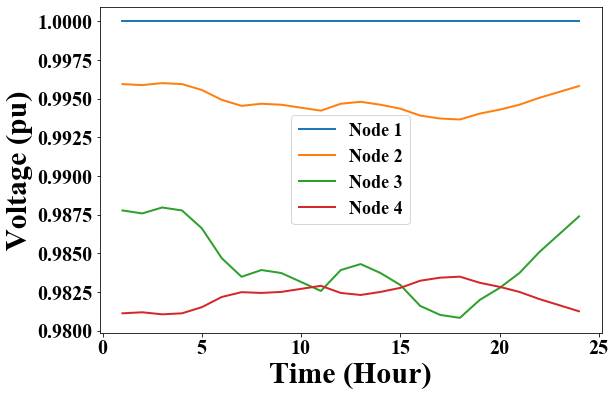

In [7]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (9, 6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['lines.linewidth'] = 2
 
mpl.rc('font',family='Times New Roman', size=18)
fnt_size=30
fnt_size2=20
csfont = {'fontname':'Times New Roman',
                  'size': fnt_size,
                 'fontweight':'bold'}
csfont2 = {'fontname':'Times New Roman',
                  'size': fnt_size2}
# voltage = np.zeros((len(ntw_p.N),))
# for i in ntw_p.N:
#     voltage[i-1]=np.sqrt(value(inst.V_i[i]))

# P_line={}
# for l in ntw_p.Lines:
#     P_line[l] = value(inst.fij_p[l])

# Gen={}
# Gen_q={}
# for i in ntw_p.N_SD:
#     Gen[i] = value(inst.Gen[i])
#     Gen_q[i] = value(inst.Gen_q[i])
voltage = np.zeros((len(ntw_p.N),len(ntw_p.time)))
for i in ntw_p.N:
    for t in ntw_p.time:
        
        voltage[i-1,t-1]=np.sqrt(value(inst.V_i[i,t]))


fig, ax = plt.subplots()


ax.plot(ntw_p.time, (voltage[0,:]), linewidth=2, label='Node 1')
ax.plot(ntw_p.time, (voltage[1,:]), linewidth=2, label='Node 2')
ax.plot(ntw_p.time, (voltage[2,:]), linewidth=2, label='Node 3')
ax.plot(ntw_p.time, (voltage[3,:]), linewidth=2, label='Node 4')

plt.xlabel("Time (Hour)",**csfont)
plt.ylabel("Voltage (pu)",**csfont)
plt.xticks(**csfont2)
plt.yticks(**csfont2)
plt.legend()


## Plotting pickup load

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 <a list of 7 Text yticklabel objects>)

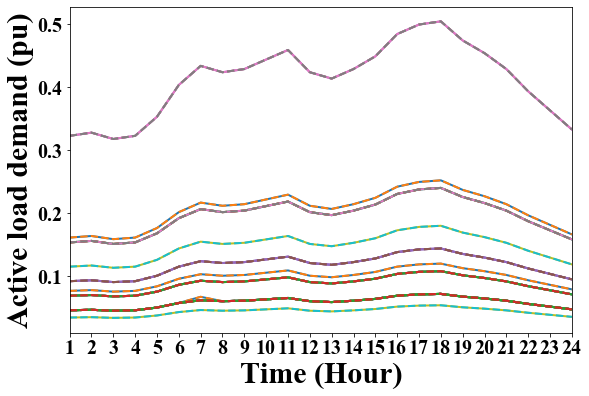

In [19]:
expected_p=np.zeros((len(ntw_p.N_load),len(ntw_p.time)))
expected_q=np.zeros((len(ntw_p.N_load),len(ntw_p.time)))
pickup_load_p =np.zeros((len(ntw_p.N_load),len(ntw_p.time)))
pickup_load_q=np.zeros((len(ntw_p.N_load),len(ntw_p.time)))

for i in ntw_p.N_load:
    k = ntw_p.N_load.index(i)
    for t in ntw_p.time:
        pickup_load_p[k,t-1] = value(inst.L_i[i,t])
        pickup_load_q[k,t-1] = value(inst.q_i[i,t])
        expected_p[k,t-1] = ntw_p.load_p[i,t]
        expected_q[k,t-1] = ntw_p.load_q[i,t]

        
# c=['blue','green','orange']        


# for j in range(len(ntw_p.N_load)):
#     label = f" {ntw_p.N_load[j]}"
    
#     plt.plot(t, pickup_load_p[j,:], linewidth=2, label=label)
w = 1    
for j in range(len(ntw_p.N_load)):
#     if j == 1:
#         w = 1.9
#     else:
#         w = 1
    label = f" {ntw_p.N_load[j]}"
    plt.plot(ntw_p.time,pickup_load_p[j,:])
    plt.plot(ntw_p.time, expected_p[j,:], '--', linewidth=2*w)
    
plt.xlabel("Time (Hour)",**csfont)
plt.ylabel("Active load demand (pu)",**csfont)

plt.xlim(1,24)
# plt.ylim(0,0.5)
plt.xticks(ntw_p.time,**csfont2)
plt.yticks(**csfont2)
# plt.legend()
# legend = plt.legend(ncol=2, title='Nodes',fontsize=20,frameon=False)
# plt.setp(legend.get_title(),fontsize=20)
# plt.savefig('./Figures/Resilience/case2/case2_load_soc50.png',dpi=700, format='png', bbox_inches='tight')

In [ ]:
sum(expected_p)

## Load loss

In [ ]:
loss_load = pickup_load_p - expected_p
sum(sum(loss_load))

In [ ]:
# plt.figure(figsize=(9,6))
# for j in range(len(ntw_p.N_load)):
#     label = f"{ntw_p.N_load[j]}"
    
#     plt.plot(t, expected_p[j,:], linewidth=2, color=c[j], label=label)
#     plt.xlabel("Time (hour)",**csfont)
#     plt.ylabel("Active load demand (pu)",**csfont)
# plt.legend(title='Nodes',frameon=False, fontsize=20)
# plt.xlim(1,24)
# plt.ylim(0,0.5)
# plt.xticks(t,**csfont2)
# plt.yticks(**csfont2)
# plt.savefig('./Figures/Resilience/expected_load.png',dpi=700, format='png', bbox_inches='tight')

## Plotting generations

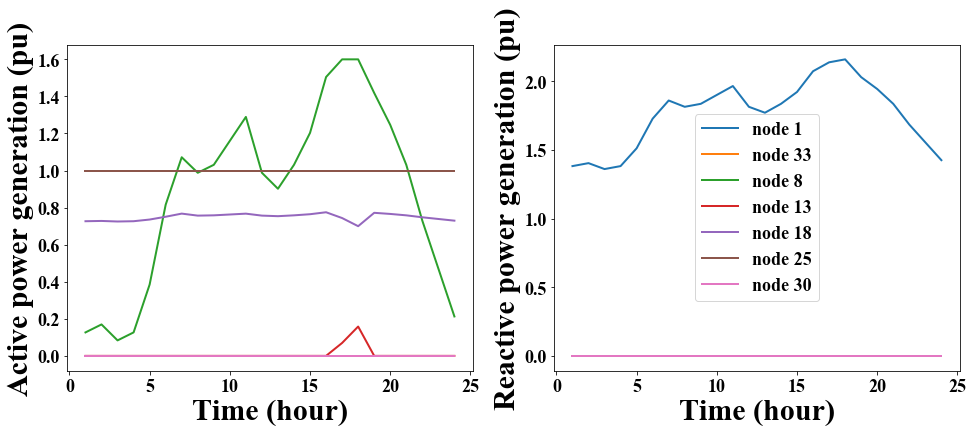

In [20]:
Gen_P=np.zeros((len(ntw_p.N_SD),len(ntw_p.time)))
Gen_Q=np.zeros((len(ntw_p.N_SD),len(ntw_p.time)))    

for i in ntw_p.N_SD:
    k = ntw_p.N_SD.index(i)
    for t in ntw_p.time:
        Gen_P[k,t-1] = value(inst.Gen_p[i,t])
        Gen_Q[k,t-1] = value(inst.Gen_q[i,t])
        
fig2, ax2 = plt.subplots(1,2, figsize=(16,6))

for j in range(len(ntw_p.N_SD)):
    label = f"node {ntw_p.N_SD[j]}"
    
    ax2[0].plot(ntw_p.time, Gen_P[j,:], linewidth=2, label=label)
    ax2[0].set_xlabel("Time (hour)",**csfont)
    ax2[0].set_ylabel("Active power generation (pu)",**csfont)
    
    ax2[1].plot(ntw_p.time, Gen_Q[j,:], linewidth=2, label=label)
    plt.xlabel("Time (hour)",**csfont)
    plt.ylabel("Reactive power generation (pu)",**csfont)
plt.legend()

In [ ]:
# Gen_P

### Plotting DSO generation

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8]),
 <a list of 11 Text yticklabel objects>)

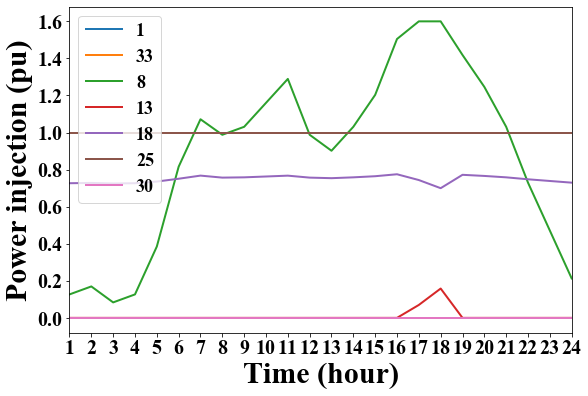

In [21]:
Gen_dso=np.zeros((len(ntw_p.N_SD), len(ntw_p.time)))
P_r = {}
for i in ntw_p.N_SD:
    k = ntw_p.N_SD.index(i)
    for t in ntw_p.time:
        Gen_dso[k,t-1] = value(inst.Gen[i,t])
        
# for i in ntw_p.N_CS:
#     k = ntw_p.N_CD.index(i)
#     for t in ntw_p.time:
#         for  e in ntw_t.EV:
#             for  r in ntw_t.R:
#                 P_r[i,r,e,t] = value(inst.P_CS_r[i,r,e,t])
        
# t = ntw_p.time
for j in range(len(ntw_p.N_SD)):
    label = f"{ntw_p.N_SD[j]}"
    
    plt.plot(ntw_p.time, Gen_dso[j,:], linewidth=2, label=label)
    plt.xlabel("Time (hour)",**csfont)
    plt.ylabel("Power injection (pu)",**csfont)
# legend = plt.legend(loc='best', bbox_to_anchor=(0.03, 0.4, 0, 0) ,ncol=2, title='Nodes',fontsize=20, frameon=False)
plt.legend()
# plt.setp(legend.get_title(),fontsize=20)
plt.xlim(1,24)
plt.xticks(ntw_p.time,**csfont2)
plt.yticks(**csfont2)
# plt.savefig('./Figures/Resilience/case2/case2_node_power_injection_soc50.png',dpi=700, format='png', bbox_inches='tight')

In [22]:
# Gen_dso=np.zeros((len(ntw_p.N_CS), len(ntw_p.time)))
# P_r = {}
# for i in ntw_p.N_CS:
#     k = ntw_p.N_CS.index(i)
#     for t in ntw_p.time:
#         Gen_dso[k,t-1] = value(inst.P_CS[i,t])
        
# # for i in ntw_p.N_CS:
# #     k = ntw_p.N_CD.index(i)
# #     for t in ntw_p.time:
# #         for  e in ntw_t.EV:
# #             for  r in ntw_t.R:
# #                 P_r[i,r,e,t] = value(inst.a_cap[i,r,e,t])
        
# t = ntw_p.time
# for j in range(len(ntw_p.N_CS)):
#     label = f"{ntw_p.N_CS[j]}"
    
#     plt.plot(t, Gen_dso[j,:], linewidth=2, label=label)
#     plt.xlabel("Time (hour)",**csfont)
#     plt.ylabel("Power injection (pu)",**csfont)
    
# plt.legend()

### Plotting marginal electricity price

In [10]:
# rho=[]
# nodes=[]
# time=[]
# for i in ntw_p.N_CD:
#     k = ntw_p.N_CD.index(i)
#     for t in ntw_p.time:
#         rho.append(inst.dual[inst.dso_con[i,t]])
#         nodes.append(i)
#         time.append(t)
        
        
# # t = ntw_p.time
# # for j in range(len(ntw_p.N_CD)):
# #     label = f"node {ntw_p.N_CD[j]}"
    
# #     plt.plot(t, rho[j,:], linewidth=2, label=label)
    
# # plt.legend()

# price = {'Nodes':nodes, 'Time':time, 'price':rho}
# price_df = pd.DataFrame(price)   

# # plt.figure(figsize=(20,10))
# ax = sns.barplot(x='Time', y='price', hue='Nodes', data=price_df)
# ax.set_xlabel("Time (hour)",**csfont)
# ax.set_ylabel(r"Energy price ($\rho$)",**csfont)
# # plt.ylim(0,26)
# plt.xticks(**csfont2)
# plt.yticks(**csfont2)
# legend = plt.legend(loc='best', bbox_to_anchor=(0.25, 0.5, 0, 0), title='Nodes',fontsize=20,frameon=False)
# # legend = plt.legend(loc='upper left', title='Nodes',fontsize=20,frameon=False,ncol=4)
# plt.setp(legend.get_title(),fontsize=20)
# # plt.savefig('./Figures/Resilience/case2/case2_energy_price_soc50.png',dpi=700, format='png', bbox_inches='tight')